In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
# Read in data
df = pd.read_csv('amazon_sample_05m.csv')
print(df.shape)
df = df.head(100000)
print(df.shape)

(500000, 4)
(100000, 4)


In [3]:
df = df.drop(['review_title', 'Unnamed: 0'], axis=1)

In [4]:
df.head()

,label,text
0,2,I bought this to wear as a joke to my brothers...
1,1,Note: Partially similar review of Vol 1.They s...
2,2,This book is a great YA read. Realistic & hear...
3,2,Well where to begin. I purchased the book and ...
4,1,"I have to say, I've purchased many books in my..."


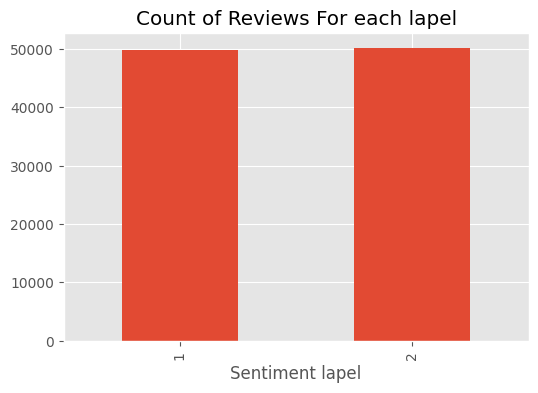

In [5]:
ax = df['label'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews For each lapel',
          figsize=(6, 4))
ax.set_xlabel('Sentiment lapel')
plt.show()

In [6]:
# Check for null values after dropping
print(np.sum(df.isnull().any(axis=1)))

# Drop null values in the data frame
df = df.dropna()

0


In [7]:
text = df['text'][50]
text

'I was really hoping that this would work well with my Motorola Rarz Maxx. I could hear the other person well, but others could barely understand me from their end. After much research at Plantronics, they said that this product will not function correctly with modern Smart Phones. Even though it has a 2.5 to 3.5 mm converter cord, the required voltage is not present with Smart Phones, whether they are iPhones, Droid OS, or other. They need USB voltage from a computer, for example. Call Plantronics and they will verify this. Plantronics is not making an appropriate 3.5 mm wired headset.I could not find a good quality Bluetooth headset until my recent purchase of the Plantronics Voyager Pro HD. It is not 100%, but amazingly good. It is available from Amazon.'

In [8]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

C:\Users\mohamed mowina\anaconda3\envs\nngpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from transformers import TFAutoModelForSequenceClassification

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [10]:
encoded_text = tokenizer(text, return_tensors='tf')
encoded_text

{'input_ids': <tf.Tensor: shape=(1, 168), dtype=int32, numpy=
array([[    0,   100,    21,   269,  2818,    14,    42,    74,   173,
          157,    19,   127, 23034,   248,   271,   329,  4471,  1178,
            4,    38,   115,  1798,     5,    97,   621,   157,     6,
           53,   643,   115,  6254,  1346,   162,    31,    49,   253,
            4,   572,   203,   557,    23, 12124, 23016,     6,    51,
           26,    14,    42,  1152,    40,    45,  5043, 12461,    19,
         2297,  5900,  4129,  6909,     4,  1648,   600,    24,    34,
           10,   132,     4,   245,     7,   155,     4,   245, 15408,
        42663, 13051,     6,     5,  1552, 31919,    16,    45,  1455,
           19,  5900,  4129,  6909,     6,   549,    51,    32, 14825,
            6, 45506,  8192,     6,    50,    97,     4,   252,   240,
        10478, 31919,    31,    10,  3034,     6,    13,  1246,     4,
         3310, 12124, 23016,     8,    51,    40, 12881,    42,     4,
        12124, 

In [11]:
output = model(encoded_text)

In [12]:
output[0][0].numpy()[0]

0.90967894

In [13]:
output = model(tokenizer(df['text'][2], return_tensors='tf'))
score = output[0][0].numpy()

In [14]:
def polarty_scores(text):
    encoded_text = tokenizer(text, return_tensors='tf')
    output = model(encoded_text)
    score = output[0][0].numpy()
    if score[0] < score[2]:
        return 1
    else:
        return 0

In [15]:
polarty_scores(df['text'][8])

0

In [16]:
df.head(10)

,label,text
0,2,I bought this to wear as a joke to my brothers...
1,1,Note: Partially similar review of Vol 1.They s...
2,2,This book is a great YA read. Realistic & hear...
3,2,Well where to begin. I purchased the book and ...
4,1,"I have to say, I've purchased many books in my..."
5,2,"okay, lets start with this: the movie is a com..."
6,2,"This is a great family movie, created from the..."
7,2,I actually read this one first...not realizing...
8,1,"Dave Matthews sucks, and so does anyone who li..."
9,1,The grater worked awful. It grates very slow a...


In [18]:
from tqdm import tqdm

num_rows = len(df)
for i, row in tqdm(df.iterrows(), total=num_rows):
  df.at[i, 'roBERTa_labels'] = polarty_scores(row['text'])


100%|██████████| 100000/100000 [10:39:53<00:00,  2.60it/s] 


In [19]:
df['label'] = df['label'].replace({1: 0, 2: 1})

In [20]:
from sklearn.metrics import accuracy_score

In [21]:
df.head()

,label,text,roBERTa_labels
0,1,I bought this to wear as a joke to my brothers...,1.0
1,0,Note: Partially similar review of Vol 1.They s...,1.0
2,1,This book is a great YA read. Realistic & hear...,1.0
3,1,Well where to begin. I purchased the book and ...,1.0
4,0,"I have to say, I've purchased many books in my...",0.0


In [26]:
accuracy = accuracy_score(df['label'], df['roBERTa_labels'])
print(f'Accuracy: {accuracy:.2%}')

Accuracy: 88.49%


In [27]:
df.to_pickle('df_roberta.pkl')